In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data_path = "/home/comet/Documents/KAIST/Data-driven/IE437_HW2/data/log.csv"

data = pd.read_csv(data_path)
print(data)

             A         B         C         D         E      score
0     0.185171  0.012469  0.643883  0.000518  0.706477  64.948380
1     0.109382  0.264447  0.830440  0.936024  0.152748  67.864240
2     0.879817  0.268302  0.687127  0.694333  0.049413  72.356650
3     0.015239  0.792621  0.065918  0.493001  0.010857  69.130690
4     0.021096  0.480832  0.964605  0.124905  0.399937  65.814804
...        ...       ...       ...       ...       ...        ...
9987  0.588501  0.666145  0.692200  0.643742  0.299264  76.598465
9988  0.203448  0.201929  0.131689  0.419674  0.506553  71.323395
9989  0.945315  0.433905  0.629868  0.453814  0.964182  69.772125
9990  0.863595  0.919242  0.512188  0.706161  0.752385  74.662800
9991  0.228581  0.622028  0.558186  0.302629  0.844547  68.673020

[9992 rows x 6 columns]


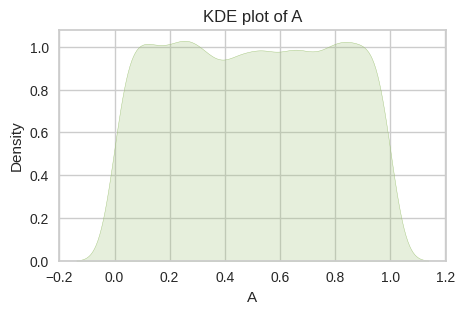

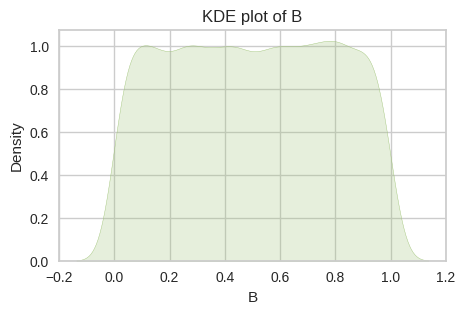

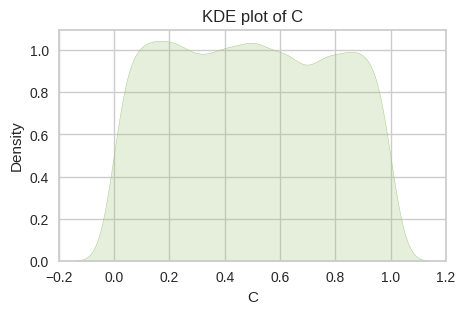

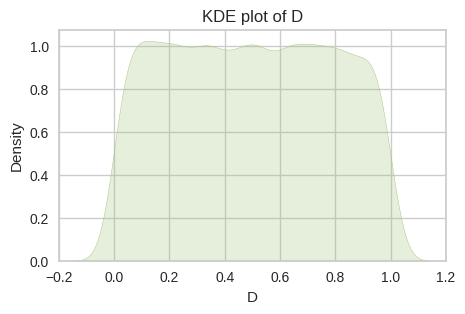

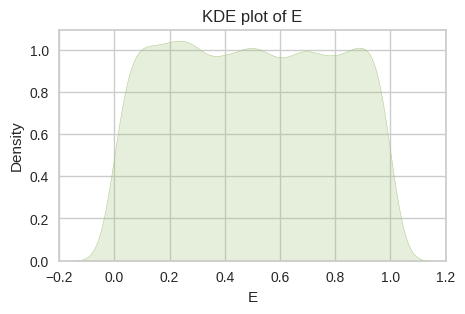

In [73]:
import seaborn as sns

# Visualize Data Distribution using KDE plot
for column in ['A', 'B', 'C', 'D', 'E']:
    plt.figure(figsize=(5, 3))
    sns.kdeplot(data[column], color='g', fill=True)
    plt.title(f'KDE plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

In [3]:
from pycaret.regression import *

exp_reg = setup(data = data, target = 'score', session_id = 123)

,Description,Value
0,Session id,123
1,Target,score
2,Target type,Regression
3,Original data shape,"(9992, 6)"
4,Transformed data shape,"(9992, 6)"
5,Transformed train set shape,"(6994, 6)"
6,Transformed test set shape,"(2998, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [4]:
best = compare_models(sort = 'MAE', n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.3593,0.2159,0.4640,0.9885,0.0063,0.0050,0.6990
et,Extra Trees Regressor,0.5240,0.4500,0.6705,0.9760,0.0091,0.0073,0.0490
gbr,Gradient Boosting Regressor,0.5413,0.6439,0.8007,0.9657,0.0103,0.0074,0.0790
rf,Random Forest Regressor,0.5680,0.5340,0.7301,0.9715,0.0098,0.0079,0.0950
knn,K Neighbors Regressor,0.6692,0.7282,0.8528,0.9611,0.0115,0.0093,0.0050
dt,Decision Tree Regressor,0.9153,1.4306,1.1955,0.9237,0.0160,0.0126,0.0070
ada,AdaBoost Regressor,1.7261,4.2255,2.0550,0.7743,0.0282,0.0243,0.0350
huber,Huber Regressor,1.8406,6.2586,2.4993,0.6666,0.0329,0.0251,0.0060
ridge,Ridge Regression,1.8618,6.1489,2.4775,0.6724,0.0328,0.0255,0.0680
br,Bayesian Ridge,1.8624,6.1489,2.4775,0.6724,0.0328,0.0255,0.0040


In [16]:
model = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3470,0.1974,0.4443,0.9902,0.0060,0.0048
1,0.3458,0.2113,0.4597,0.9886,0.0062,0.0048
2,0.3885,0.2721,0.5216,0.9856,0.0069,0.0053
3,0.3667,0.2273,0.4768,0.9878,0.0064,0.0051
4,0.3349,0.1804,0.4247,0.9903,0.0058,0.0047
5,0.3515,0.2114,0.4598,0.9890,0.0062,0.0049
6,0.3734,0.2349,0.4847,0.9875,0.0066,0.0052
7,0.3686,0.2273,0.4768,0.9878,0.0065,0.0051
8,0.3540,0.1977,0.4447,0.9891,0.0060,0.0049


In [11]:
print(model)

LGBMRegressor(n_jobs=-1, random_state=123)


In [15]:
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [17]:
# hyperparameter tuning 
tuned_model = tune_model(model)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4191,0.3062,0.5534,0.9848,0.0073,0.0057
1,0.3869,0.2664,0.5161,0.9856,0.0069,0.0053
2,0.4632,0.3965,0.6297,0.9790,0.0082,0.0063
3,0.4206,0.3068,0.5539,0.9835,0.0074,0.0058
4,0.3898,0.2559,0.5059,0.9863,0.0068,0.0054
5,0.4102,0.2848,0.5337,0.9852,0.0071,0.0056
6,0.4279,0.3202,0.5659,0.9829,0.0076,0.0059
7,0.4101,0.2975,0.5454,0.9840,0.0073,0.0057
8,0.4001,0.2677,0.5174,0.9852,0.0069,0.0055


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [25]:
from skopt import gp_minimize

def objective(values):
    # 하이퍼파라미터 설정
    params = {'learning_rate': [values[0]], 'n_estimators': [values[1]]}

    # 모델 튜닝
    tuned_model = tune_model(model, custom_grid = params)

    # 모델 성능 반환 (최소화 문제로 변환)
    return -1.0 * pull().iloc[-1]['R2']

# 베이지안 최적화
res = gp_minimize(objective, [(0.01, 1), (100, 1000)])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5740,0.5592,0.7478,0.9722,0.0100,0.0079
1,0.5524,0.5131,0.7163,0.9723,0.0097,0.0077
2,0.6020,0.6282,0.7926,0.9667,0.0106,0.0083
3,0.5599,0.5423,0.7364,0.9709,0.0099,0.0077
4,0.5231,0.4741,0.6886,0.9746,0.0093,0.0073
5,0.5679,0.5309,0.7286,0.9725,0.0099,0.0078
6,0.5810,0.5913,0.7690,0.9685,0.0104,0.0081
7,0.5776,0.5715,0.7560,0.9692,0.0102,0.0080
8,0.5692,0.5311,0.7287,0.9707,0.0099,0.0079


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5388,0.4796,0.6925,0.9762,0.0093,0.0074
1,0.5366,0.4850,0.6964,0.9738,0.0094,0.0074
2,0.5531,0.5473,0.7398,0.9710,0.0099,0.0076
3,0.5505,0.5197,0.7209,0.9721,0.0098,0.0076
4,0.5287,0.4699,0.6855,0.9748,0.0093,0.0074
5,0.5256,0.4598,0.6781,0.9762,0.0092,0.0073
6,0.5345,0.4853,0.6967,0.9742,0.0094,0.0074
7,0.5423,0.5037,0.7097,0.9729,0.0096,0.0075
8,0.5377,0.4780,0.6914,0.9736,0.0094,0.0074


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.662667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.655743
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5388,0.4796,0.6925,0.9762,0.0093,0.0074
1,0.5366,0.4850,0.6964,0.9738,0.0094,0.0074
2,0.5531,0.5473,0.7398,0.9710,0.0099,0.0076
3,0.5505,0.5197,0.7209,0.9721,0.0098,0.0076
4,0.5287,0.4699,0.6855,0.9748,0.0093,0.0074
5,0.5256,0.4598,0.6781,0.9762,0.0092,0.0073
6,0.5345,0.4853,0.6967,0.9742,0.0094,0.0074
7,0.5423,0.5037,0.7097,0.9729,0.0096,0.0075
8,0.5377,0.4780,0.6914,0.9736,0.0094,0.0074


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5388,0.4796,0.6925,0.9762,0.0093,0.0074
1,0.5366,0.4850,0.6964,0.9738,0.0094,0.0074
2,0.5531,0.5473,0.7398,0.9710,0.0099,0.0076
3,0.5505,0.5197,0.7209,0.9721,0.0098,0.0076
4,0.5287,0.4699,0.6855,0.9748,0.0093,0.0074
5,0.5256,0.4598,0.6781,0.9762,0.0092,0.0073
6,0.5345,0.4853,0.6967,0.9742,0.0094,0.0074
7,0.5423,0.5037,0.7097,0.9729,0.0096,0.0075
8,0.5377,0.4780,0.6914,0.9736,0.0094,0.0074


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.614022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Start training from score 71.6453

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5388,0.4796,0.6925,0.9762,0.0093,0.0074
1,0.5366,0.4850,0.6964,0.9738,0.0094,0.0074
2,0.5531,0.5473,0.7398,0.9710,0.0099,0.0076
3,0.5505,0.5197,0.7209,0.9721,0.0098,0.0076
4,0.5287,0.4699,0.6855,0.9748,0.0093,0.0074
5,0.5256,0.4598,0.6781,0.9762,0.0092,0.0073
6,0.5345,0.4853,0.6967,0.9742,0.0094,0.0074
7,0.5423,0.5037,0.7097,0.9729,0.0096,0.0075
8,0.5377,0.4780,0.6914,0.9736,0.0094,0.0074


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5388,0.4796,0.6925,0.9762,0.0093,0.0074
1,0.5366,0.4850,0.6964,0.9738,0.0094,0.0074
2,0.5531,0.5473,0.7398,0.9710,0.0099,0.0076
3,0.5505,0.5197,0.7209,0.9721,0.0098,0.0076
4,0.5287,0.4699,0.6855,0.9748,0.0093,0.0074
5,0.5256,0.4598,0.6781,0.9762,0.0092,0.0073
6,0.5345,0.4853,0.6967,0.9742,0.0094,0.0074
7,0.5423,0.5037,0.7097,0.9729,0.0096,0.0075
8,0.5377,0.4780,0.6914,0.9736,0.0094,0.0074


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.605694
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5388,0.4796,0.6925,0.9762,0.0093,0.0074
1,0.5366,0.4850,0.6964,0.9738,0.0094,0.0074
2,0.5531,0.5473,0.7398,0.9710,0.0099,0.0076
3,0.5505,0.5197,0.7209,0.9721,0.0098,0.0076
4,0.5287,0.4699,0.6855,0.9748,0.0093,0.0074
5,0.5256,0.4598,0.6781,0.9762,0.0092,0.0073
6,0.5345,0.4853,0.6967,0.9742,0.0094,0.0074
7,0.5423,0.5037,0.7097,0.9729,0.0096,0.0075
8,0.5377,0.4780,0.6914,0.9736,0.0094,0.0074


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5388,0.4796,0.6925,0.9762,0.0093,0.0074
1,0.5366,0.4850,0.6964,0.9738,0.0094,0.0074
2,0.5531,0.5473,0.7398,0.9710,0.0099,0.0076
3,0.5505,0.5197,0.7209,0.9721,0.0098,0.0076
4,0.5287,0.4699,0.6855,0.9748,0.0093,0.0074
5,0.5256,0.4598,0.6781,0.9762,0.0092,0.0073
6,0.5345,0.4853,0.6967,0.9742,0.0094,0.0074
7,0.5423,0.5037,0.7097,0.9729,0.0096,0.0075
8,0.5377,0.4780,0.6914,0.9736,0.0094,0.0074


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-c

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5388,0.4796,0.6925,0.9762,0.0093,0.0074
1,0.5366,0.4850,0.6964,0.9738,0.0094,0.0074
2,0.5531,0.5473,0.7398,0.9710,0.0099,0.0076
3,0.5505,0.5197,0.7209,0.9721,0.0098,0.0076
4,0.5287,0.4699,0.6855,0.9748,0.0093,0.0074
5,0.5256,0.4598,0.6781,0.9762,0.0092,0.0073
6,0.5345,0.4853,0.6967,0.9742,0.0094,0.0074
7,0.5423,0.5037,0.7097,0.9729,0.0096,0.0075
8,0.5377,0.4780,0.6914,0.9736,0.0094,0.0074


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Number of data points in the trai

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5388,0.4796,0.6925,0.9762,0.0093,0.0074
1,0.5366,0.4850,0.6964,0.9738,0.0094,0.0074
2,0.5531,0.5473,0.7398,0.9710,0.0099,0.0076
3,0.5505,0.5197,0.7209,0.9721,0.0098,0.0076
4,0.5287,0.4699,0.6855,0.9748,0.0093,0.0074
5,0.5256,0.4598,0.6781,0.9762,0.0092,0.0073
6,0.5345,0.4853,0.6967,0.9742,0.0094,0.0074
7,0.5423,0.5037,0.7097,0.9729,0.0096,0.0075
8,0.5377,0.4780,0.6914,0.9736,0.0094,0.0074


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4678,0.3834,0.6192,0.9809,0.0083,0.0065
1,0.4352,0.3412,0.5841,0.9816,0.0078,0.0060
2,0.4583,0.3540,0.5950,0.9813,0.0080,0.0063
3,0.4398,0.3433,0.5860,0.9816,0.0078,0.0061
4,0.4297,0.3219,0.5673,0.9827,0.0077,0.0060
5,0.4502,0.3333,0.5773,0.9827,0.0078,0.0062
6,0.4515,0.3498,0.5914,0.9814,0.0080,0.0063
7,0.4271,0.3309,0.5752,0.9822,0.0077,0.0059
8,0.4628,0.3506,0.5921,0.9806,0.0080,0.0064


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.662667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.605694
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5851,0.5806,0.7620,0.9712,0.0103,0.0081
1,0.5777,0.5817,0.7627,0.9686,0.0102,0.0080
2,0.5812,0.5684,0.7539,0.9699,0.0102,0.0080
3,0.5966,0.5944,0.7710,0.9681,0.0104,0.0083
4,0.5745,0.5598,0.7482,0.9700,0.0102,0.0080
5,0.5467,0.5036,0.7096,0.9739,0.0096,0.0076
6,0.5278,0.4804,0.6931,0.9744,0.0094,0.0073
7,0.5600,0.5381,0.7335,0.9710,0.0099,0.0078
8,0.5702,0.5557,0.7455,0.9693,0.0101,0.0079


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001637 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Start training from score 71.662667[LightGBM] [Info] Total Bins 127

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5467,0.5025,0.7089,0.9750,0.0095,0.0075
1,0.5205,0.4825,0.6947,0.9740,0.0093,0.0072
2,0.5459,0.5069,0.7120,0.9732,0.0095,0.0075
3,0.5292,0.4730,0.6878,0.9746,0.0093,0.0073
4,0.5188,0.4553,0.6748,0.9756,0.0092,0.0072
5,0.5543,0.5322,0.7296,0.9724,0.0099,0.0077
6,0.5264,0.4656,0.6824,0.9752,0.0092,0.0073
7,0.5071,0.4676,0.6838,0.9748,0.0092,0.0070
8,0.5491,0.4963,0.7045,0.9726,0.0095,0.0076


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.662667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5679,0.5335,0.7304,0.9735,0.0098,0.0078
1,0.5518,0.5246,0.7243,0.9717,0.0097,0.0076
2,0.5810,0.5633,0.7505,0.9702,0.0101,0.0080
3,0.5258,0.4843,0.6959,0.9740,0.0094,0.0073
4,0.5608,0.5441,0.7377,0.9708,0.0100,0.0078
5,0.5715,0.5458,0.7388,0.9717,0.0100,0.0079
6,0.5848,0.6233,0.7895,0.9668,0.0106,0.0081
7,0.5418,0.5073,0.7122,0.9727,0.0096,0.0075
8,0.5739,0.5480,0.7402,0.9698,0.0100,0.0079


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.662667
[LightGBM] [Info] Start training from score 71.605694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3363,0.1883,0.4340,0.9906,0.0058,0.0046
1,0.3369,0.1963,0.4430,0.9894,0.0060,0.0047
2,0.3675,0.2424,0.4923,0.9872,0.0065,0.0051
3,0.3447,0.1988,0.4458,0.9893,0.0060,0.0048
4,0.3228,0.1667,0.4083,0.9911,0.0056,0.0045
5,0.3455,0.2007,0.4480,0.9896,0.0060,0.0048
6,0.3590,0.2158,0.4645,0.9885,0.0063,0.0050
7,0.3413,0.2007,0.4480,0.9892,0.0061,0.0047
8,0.3252,0.1724,0.4152,0.9905,0.0056,0.0045


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.662667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.614022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, yo

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8090,1.1304,1.0632,0.9438,0.0144,0.0112
1,0.7748,0.9834,0.9916,0.9469,0.0135,0.0108
2,0.7734,0.9833,0.9916,0.9479,0.0135,0.0107
3,0.7532,1.0017,1.0008,0.9462,0.0136,0.0104
4,0.7814,1.0492,1.0243,0.9437,0.0140,0.0109
5,0.7378,0.8976,0.9474,0.9535,0.0130,0.0103
6,0.7556,0.9427,0.9709,0.9498,0.0132,0.0105
7,0.7018,0.8774,0.9367,0.9527,0.0126,0.0097
8,0.7602,0.9727,0.9863,0.9463,0.0134,0.0105


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7426,0.9622,0.9809,0.9522,0.0132,0.0102
1,0.7373,0.8997,0.9485,0.9514,0.0129,0.0103
2,0.7640,0.9604,0.9800,0.9491,0.0134,0.0106
3,0.7393,0.8996,0.9485,0.9517,0.0129,0.0103
4,0.7747,0.9800,0.9899,0.9474,0.0135,0.0108
5,0.7283,0.8638,0.9294,0.9552,0.0127,0.0101
6,0.6849,0.8299,0.9110,0.9558,0.0123,0.0095
7,0.6850,0.8232,0.9073,0.9557,0.0123,0.0095
8,0.7152,0.8435,0.9184,0.9534,0.0125,0.0099


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6832,0.7886,0.8880,0.9608,0.0120,0.0095
1,0.6991,0.8207,0.9059,0.9557,0.0122,0.0097
2,0.6925,0.8628,0.9289,0.9543,0.0125,0.0096
3,0.7037,0.8431,0.9182,0.9547,0.0124,0.0097
4,0.6999,0.8332,0.9128,0.9553,0.0124,0.0097
5,0.6767,0.7651,0.8747,0.9603,0.0119,0.0094
6,0.6907,0.8005,0.8947,0.9574,0.0121,0.0096
7,0.6535,0.7181,0.8474,0.9613,0.0116,0.0091
8,0.7104,0.8323,0.9123,0.9541,0.0124,0.0098


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.615037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6788,0.7544,0.8685,0.9625,0.0117,0.0094
1,0.6060,0.6235,0.7896,0.9663,0.0108,0.0084
2,0.6521,0.7348,0.8572,0.9611,0.0116,0.0090
3,0.6019,0.6146,0.7840,0.9670,0.0107,0.0084
4,0.6145,0.6454,0.8034,0.9654,0.0109,0.0085
5,0.6614,0.7002,0.8368,0.9637,0.0114,0.0092
6,0.6334,0.6960,0.8343,0.9629,0.0113,0.0088
7,0.6191,0.6574,0.8108,0.9646,0.0109,0.0086
8,0.6452,0.6846,0.8274,0.9622,0.0112,0.0089


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Start training from score 71.655743
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3495,0.2043,0.4520,0.9899,0.0060,0.0048
1,0.3470,0.2109,0.4593,0.9886,0.0062,0.0048
2,0.3757,0.2448,0.4948,0.9870,0.0066,0.0052
3,0.3459,0.2086,0.4567,0.9888,0.0061,0.0048
4,0.3386,0.1905,0.4365,0.9898,0.0059,0.0047
5,0.3553,0.2092,0.4574,0.9892,0.0062,0.0049
6,0.3659,0.2214,0.4706,0.9882,0.0064,0.0051
7,0.3400,0.1905,0.4364,0.9897,0.0059,0.0047
8,0.3437,0.1982,0.4452,0.9891,0.0060,0.0048


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4248,0.3070,0.5540,0.9847,0.0074,0.0059
1,0.3933,0.2695,0.5191,0.9855,0.0070,0.0054
2,0.4511,0.3640,0.6033,0.9807,0.0080,0.0062
3,0.4229,0.3018,0.5494,0.9838,0.0074,0.0058
4,0.4077,0.2829,0.5319,0.9848,0.0071,0.0056
5,0.4220,0.2902,0.5387,0.9850,0.0072,0.0058
6,0.4405,0.3314,0.5756,0.9824,0.0077,0.0061
7,0.4135,0.2887,0.5373,0.9844,0.0073,0.0057
8,0.4096,0.2678,0.5175,0.9852,0.0070,0.0057


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3078,0.1643,0.4053,0.9918,0.0054,0.0042
1,0.2851,0.1372,0.3704,0.9926,0.0050,0.0039
2,0.3113,0.1729,0.4158,0.9908,0.0055,0.0043
3,0.2943,0.1521,0.3900,0.9918,0.0052,0.0041
4,0.2680,0.1209,0.3477,0.9935,0.0047,0.0037
5,0.3010,0.1544,0.3929,0.9920,0.0053,0.0041
6,0.3014,0.1531,0.3913,0.9918,0.0053,0.0042
7,0.2931,0.1454,0.3813,0.9922,0.0052,0.0041
8,0.2923,0.1430,0.3781,0.9921,0.0051,0.0040


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003512 seconds.
Y

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4782,0.4117,0.6416,0.9795,0.0086,0.0066
1,0.4790,0.4054,0.6367,0.9781,0.0085,0.0066
2,0.5271,0.4872,0.6980,0.9742,0.0094,0.0073
3,0.5081,0.4498,0.6707,0.9759,0.0090,0.0070
4,0.4681,0.3724,0.6102,0.9800,0.0083,0.0065
5,0.5190,0.4483,0.6696,0.9768,0.0090,0.0072
6,0.4644,0.3721,0.6100,0.9802,0.0082,0.0064
7,0.4901,0.3988,0.6315,0.9785,0.0085,0.0068
8,0.4793,0.3908,0.6251,0.9784,0.0084,0.0066


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Total Bins 1275[LightGBM] [Info] Start training from score 71.614022

[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6446,0.6951,0.8337,0.9655,0.0112,0.0089
1,0.6068,0.6124,0.7826,0.9669,0.0106,0.0084
2,0.6168,0.6398,0.7999,0.9661,0.0108,0.0085
3,0.6175,0.6373,0.7983,0.9658,0.0108,0.0086
4,0.5942,0.6082,0.7799,0.9674,0.0105,0.0082
5,0.5813,0.5625,0.7500,0.9708,0.0102,0.0080
6,0.6332,0.6945,0.8334,0.9630,0.0112,0.0088
7,0.5910,0.6058,0.7783,0.9674,0.0105,0.0082
8,0.6230,0.6621,0.8137,0.9634,0.0110,0.0086


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.614022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4423,0.3266,0.5715,0.9838,0.0077,0.0061
1,0.4163,0.2950,0.5431,0.9841,0.0073,0.0058
2,0.4125,0.2913,0.5398,0.9846,0.0072,0.0057
3,0.4183,0.2877,0.5364,0.9846,0.0072,0.0058
4,0.4226,0.2990,0.5468,0.9840,0.0074,0.0059
5,0.4303,0.2990,0.5468,0.9845,0.0074,0.0060
6,0.4179,0.3035,0.5509,0.9838,0.0074,0.0058
7,0.4371,0.3239,0.5691,0.9826,0.0077,0.0061
8,0.4178,0.2909,0.5394,0.9839,0.0073,0.0058


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3753,0.2328,0.4825,0.9884,0.0065,0.0052
1,0.3667,0.2289,0.4785,0.9876,0.0065,0.0051
2,0.3737,0.2565,0.5065,0.9864,0.0068,0.0051
3,0.3946,0.2608,0.5107,0.9860,0.0068,0.0054
4,0.3621,0.2106,0.4589,0.9887,0.0062,0.0050
5,0.3663,0.2275,0.4770,0.9882,0.0064,0.0051
6,0.3665,0.2225,0.4717,0.9881,0.0064,0.0051
7,0.3545,0.2093,0.4575,0.9887,0.0062,0.0049
8,0.3682,0.2120,0.4605,0.9883,0.0062,0.0051


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.662667
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3540,0.2040,0.4517,0.9899,0.0060,0.0049
1,0.3431,0.1975,0.4444,0.9893,0.0060,0.0048
2,0.3687,0.2372,0.4871,0.9874,0.0065,0.0051
3,0.3527,0.2091,0.4572,0.9888,0.0061,0.0049
4,0.3243,0.1738,0.4168,0.9907,0.0057,0.0045
5,0.3351,0.1904,0.4363,0.9901,0.0059,0.0046
6,0.3404,0.1983,0.4453,0.9894,0.0060,0.0047
7,0.3420,0.1925,0.4387,0.9896,0.0059,0.0048
8,0.3341,0.1839,0.4288,0.9898,0.0058,0.0046


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3418,0.1980,0.4450,0.9902,0.0059,0.0047
1,0.3343,0.1931,0.4395,0.9896,0.0059,0.0046
2,0.3767,0.2506,0.5006,0.9867,0.0067,0.0052
3,0.3610,0.2138,0.4624,0.9885,0.0062,0.0050
4,0.3209,0.1633,0.4041,0.9912,0.0055,0.0045
5,0.3387,0.1999,0.4471,0.9896,0.0060,0.0047
6,0.3559,0.2131,0.4616,0.9887,0.0063,0.0049
7,0.3457,0.2051,0.4529,0.9890,0.0061,0.0048
8,0.3274,0.1768,0.4205,0.9902,0.0057,0.0045


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3486,0.1989,0.4460,0.9901,0.0060,0.0048
1,0.3366,0.2003,0.4475,0.9892,0.0060,0.0047
2,0.3844,0.2648,0.5146,0.9860,0.0068,0.0053
3,0.3579,0.2134,0.4619,0.9885,0.0062,0.0049
4,0.3290,0.1736,0.4167,0.9907,0.0057,0.0046
5,0.3525,0.2100,0.4583,0.9891,0.0062,0.0049
6,0.3671,0.2245,0.4738,0.9880,0.0064,0.0051
7,0.3544,0.2122,0.4607,0.9886,0.0062,0.0049
8,0.3393,0.1859,0.4312,0.9897,0.0059,0.0047


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.662667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.605694
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6801,0.7910,0.8894,0.9607,0.0120,0.0094
1,0.6827,0.8142,0.9023,0.9560,0.0121,0.0094
2,0.6701,0.7582,0.8708,0.9598,0.0118,0.0093
3,0.6470,0.6963,0.8344,0.9626,0.0113,0.0090
4,0.6929,0.8095,0.8997,0.9566,0.0122,0.0096
5,0.6629,0.7384,0.8593,0.9617,0.0117,0.0092
6,0.6683,0.7511,0.8667,0.9600,0.0118,0.0093
7,0.6535,0.7316,0.8554,0.9606,0.0115,0.0091
8,0.6345,0.6935,0.8328,0.9617,0.0112,0.0088


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4944,0.4206,0.6485,0.9791,0.0086,0.0068
1,0.4956,0.4257,0.6524,0.9770,0.0088,0.0069
2,0.5050,0.4293,0.6552,0.9773,0.0088,0.0070
3,0.4872,0.4026,0.6345,0.9784,0.0086,0.0067
4,0.4745,0.3772,0.6142,0.9798,0.0083,0.0066
5,0.4870,0.3848,0.6203,0.9801,0.0084,0.0067
6,0.4898,0.4171,0.6459,0.9778,0.0087,0.0068
7,0.4860,0.3790,0.6156,0.9796,0.0083,0.0067
8,0.4853,0.3905,0.6249,0.9784,0.0084,0.0067


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.615037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5334,0.4715,0.6867,0.9766,0.0092,0.0073
1,0.4894,0.4073,0.6382,0.9780,0.0087,0.0068
2,0.5205,0.4933,0.7023,0.9739,0.0094,0.0072
3,0.5363,0.4879,0.6985,0.9738,0.0095,0.0074
4,0.4843,0.4180,0.6465,0.9776,0.0088,0.0067
5,0.5083,0.4342,0.6589,0.9775,0.0089,0.0070
6,0.5350,0.5052,0.7108,0.9731,0.0096,0.0074
7,0.5045,0.4394,0.6629,0.9763,0.0089,0.0070
8,0.5071,0.4212,0.6490,0.9767,0.0088,0.0070


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7385,0.9187,0.9585,0.9544,0.0130,0.0102
1,0.7721,1.0220,1.0110,0.9448,0.0137,0.0107
2,0.7016,0.8565,0.9255,0.9546,0.0125,0.0097
3,0.6520,0.6823,0.8260,0.9634,0.0113,0.0091
4,0.6796,0.7730,0.8792,0.9585,0.0121,0.0095
5,0.6938,0.8323,0.9123,0.9569,0.0124,0.0096
6,0.7665,1.0118,1.0059,0.9461,0.0136,0.0106
7,0.6637,0.7531,0.8678,0.9594,0.0119,0.0093
8,0.7051,0.8243,0.9079,0.9545,0.0123,0.0098


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6923,0.8207,0.9059,0.9592,0.0122,0.0096
1,0.6743,0.7812,0.8839,0.9578,0.0120,0.0094
2,0.6905,0.8308,0.9115,0.9560,0.0123,0.0095
3,0.6530,0.7362,0.8580,0.9605,0.0116,0.0091
4,0.6558,0.7376,0.8588,0.9604,0.0115,0.0091
5,0.6932,0.7886,0.8880,0.9591,0.0121,0.0096
6,0.6994,0.8334,0.9129,0.9556,0.0123,0.0097
7,0.6707,0.7644,0.8743,0.9588,0.0119,0.0093
8,0.6991,0.7922,0.8901,0.9563,0.0121,0.0097


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6051,0.5860,0.7655,0.9709,0.0103,0.0083
1,0.5910,0.5798,0.7615,0.9687,0.0103,0.0082
2,0.6157,0.6662,0.8162,0.9647,0.0110,0.0085
3,0.5868,0.6023,0.7761,0.9677,0.0105,0.0081
4,0.5956,0.5936,0.7704,0.9682,0.0105,0.0083
5,0.5690,0.5358,0.7320,0.9722,0.0099,0.0079
6,0.6146,0.6449,0.8030,0.9657,0.0109,0.0085
7,0.5573,0.5419,0.7361,0.9708,0.0099,0.0077
8,0.5928,0.5855,0.7652,0.9677,0.0104,0.0082


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4050,0.2724,0.5219,0.9865,0.0070,0.0056
1,0.3796,0.2452,0.4951,0.9868,0.0067,0.0053
2,0.4197,0.3012,0.5488,0.9841,0.0073,0.0058
3,0.4098,0.2767,0.5261,0.9851,0.0071,0.0057
4,0.3686,0.2131,0.4616,0.9886,0.0063,0.0051
5,0.3893,0.2512,0.5012,0.9870,0.0067,0.0054
6,0.3987,0.2680,0.5177,0.9857,0.0070,0.0055
7,0.3771,0.2521,0.5021,0.9864,0.0068,0.0052
8,0.3866,0.2444,0.4944,0.9865,0.0067,0.0054


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Start training from score 71.614022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4242,0.3204,0.5661,0.9841,0.0076,0.0058
1,0.4391,0.3185,0.5643,0.9828,0.0076,0.0061
2,0.4668,0.3985,0.6313,0.9789,0.0084,0.0064
3,0.4553,0.3403,0.5834,0.9817,0.0079,0.0063
4,0.4536,0.3513,0.5927,0.9812,0.0080,0.0063
5,0.4313,0.3070,0.5541,0.9841,0.0075,0.0060
6,0.4609,0.3629,0.6024,0.9807,0.0081,0.0064
7,0.4491,0.3336,0.5776,0.9820,0.0078,0.0062
8,0.4496,0.3227,0.5681,0.9822,0.0077,0.0062


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the trai

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6536,0.7306,0.8548,0.9637,0.0115,0.0090
1,0.6315,0.6865,0.8286,0.9629,0.0111,0.0087
2,0.6230,0.6743,0.8212,0.9643,0.0110,0.0086
3,0.6090,0.6364,0.7978,0.9658,0.0108,0.0084
4,0.6341,0.6951,0.8337,0.9627,0.0113,0.0088
5,0.5837,0.5553,0.7452,0.9712,0.0101,0.0081
6,0.6616,0.7404,0.8605,0.9606,0.0116,0.0091
7,0.6251,0.6503,0.8064,0.9650,0.0109,0.0087
8,0.6418,0.6788,0.8239,0.9625,0.0111,0.0089


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3582,0.2317,0.4814,0.9885,0.0064,0.0049
1,0.3321,0.1846,0.4297,0.9900,0.0058,0.0046
2,0.3747,0.2470,0.4970,0.9869,0.0066,0.0052
3,0.3469,0.2123,0.4607,0.9886,0.0062,0.0048
4,0.3317,0.1824,0.4271,0.9902,0.0058,0.0046
5,0.3540,0.2117,0.4601,0.9890,0.0062,0.0049
6,0.3507,0.2135,0.4620,0.9886,0.0063,0.0049
7,0.3660,0.2219,0.4711,0.9880,0.0064,0.0051
8,0.3583,0.2078,0.4558,0.9885,0.0062,0.0050


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2918,0.1433,0.3785,0.9929,0.0051,0.0040
1,0.2821,0.1360,0.3688,0.9927,0.0050,0.0039
2,0.3008,0.1717,0.4144,0.9909,0.0055,0.0041
3,0.2907,0.1469,0.3833,0.9921,0.0051,0.0040
4,0.2680,0.1185,0.3442,0.9936,0.0047,0.0037
5,0.2974,0.1481,0.3848,0.9923,0.0052,0.0041
6,0.2899,0.1428,0.3778,0.9924,0.0051,0.0040
7,0.2814,0.1323,0.3638,0.9929,0.0049,0.0039
8,0.2748,0.1250,0.3536,0.9931,0.0048,0.0038


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.662667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3749,0.2372,0.4870,0.9882,0.0066,0.0052
1,0.3596,0.2167,0.4655,0.9883,0.0063,0.0050
2,0.3854,0.2664,0.5162,0.9859,0.0069,0.0053
3,0.4033,0.2667,0.5164,0.9857,0.0069,0.0056
4,0.3623,0.2160,0.4648,0.9884,0.0063,0.0050
5,0.3812,0.2408,0.4907,0.9875,0.0067,0.0053
6,0.4097,0.2856,0.5345,0.9848,0.0072,0.0057
7,0.3860,0.2519,0.5019,0.9864,0.0068,0.0053
8,0.3916,0.2473,0.4973,0.9863,0.0067,0.0054


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.614022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2851,0.1382,0.3717,0.9931,0.0050,0.0039
1,0.2635,0.1244,0.3527,0.9933,0.0047,0.0036
2,0.2920,0.1609,0.4012,0.9915,0.0053,0.0040
3,0.2729,0.1255,0.3543,0.9933,0.0048,0.0038
4,0.2602,0.1107,0.3326,0.9941,0.0045,0.0036
5,0.2817,0.1340,0.3661,0.9931,0.0049,0.0039
6,0.2934,0.1445,0.3801,0.9923,0.0051,0.0041
7,0.2710,0.1253,0.3540,0.9932,0.0048,0.0038
8,0.2724,0.1206,0.3473,0.9933,0.0047,0.0038


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3538,0.2099,0.4581,0.9896,0.0061,0.0049
1,0.3257,0.1812,0.4256,0.9902,0.0058,0.0045
2,0.3642,0.2377,0.4876,0.9874,0.0065,0.0050
3,0.3387,0.2020,0.4494,0.9892,0.0060,0.0047
4,0.3253,0.1753,0.4187,0.9906,0.0057,0.0045
5,0.3647,0.2243,0.4737,0.9884,0.0064,0.0050
6,0.3569,0.2123,0.4607,0.9887,0.0063,0.0050
7,0.3433,0.1923,0.4385,0.9896,0.0060,0.0048
8,0.3474,0.2019,0.4494,0.9889,0.0061,0.0048


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4146,0.2868,0.5356,0.9857,0.0072,0.0057
1,0.3928,0.2658,0.5156,0.9857,0.0069,0.0054
2,0.4217,0.3107,0.5574,0.9835,0.0075,0.0058
3,0.4035,0.2731,0.5226,0.9853,0.0070,0.0056
4,0.4020,0.2693,0.5189,0.9856,0.0070,0.0056
5,0.3908,0.2629,0.5128,0.9864,0.0069,0.0054
6,0.4031,0.2779,0.5272,0.9852,0.0071,0.0056
7,0.4236,0.3071,0.5541,0.9835,0.0074,0.0059
8,0.3884,0.2453,0.4953,0.9865,0.0067,0.0054


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Start training from score 71.615037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2930,0.1400,0.3741,0.9930,0.0050,0.0040
1,0.2861,0.1438,0.3793,0.9922,0.0051,0.0040
2,0.3073,0.1743,0.4175,0.9908,0.0055,0.0042
3,0.2949,0.1468,0.3832,0.9921,0.0052,0.0041
4,0.2766,0.1237,0.3517,0.9934,0.0048,0.0038
5,0.2857,0.1418,0.3766,0.9926,0.0051,0.0039
6,0.2937,0.1492,0.3862,0.9921,0.0052,0.0041
7,0.2834,0.1414,0.3760,0.9924,0.0051,0.0039
8,0.2779,0.1250,0.3535,0.9931,0.0048,0.0039


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.655743
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5159,0.4558,0.6751,0.9774,0.0091,0.0071
1,0.5434,0.5124,0.7158,0.9723,0.0096,0.0075
2,0.5112,0.4499,0.6707,0.9762,0.0090,0.0071
3,0.5224,0.4686,0.6845,0.9748,0.0092,0.0072
4,0.5061,0.4235,0.6508,0.9773,0.0088,0.0070
5,0.5209,0.4644,0.6815,0.9759,0.0092,0.0072
6,0.5349,0.4719,0.6869,0.9749,0.0094,0.0074
7,0.5014,0.4288,0.6548,0.9769,0.0089,0.0070
8,0.5423,0.4735,0.6881,0.9739,0.0093,0.0075


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.615037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5259,0.4465,0.6682,0.9778,0.0090,0.0072
1,0.4831,0.3831,0.6190,0.9793,0.0084,0.0067
2,0.5150,0.4501,0.6709,0.9762,0.0090,0.0071
3,0.5000,0.4173,0.6460,0.9776,0.0088,0.0069
4,0.4958,0.4108,0.6410,0.9780,0.0087,0.0069
5,0.5074,0.4164,0.6453,0.9784,0.0087,0.0070
6,0.5026,0.4289,0.6549,0.9772,0.0089,0.0070
7,0.5039,0.4396,0.6631,0.9763,0.0088,0.0069
8,0.4903,0.3898,0.6243,0.9785,0.0085,0.0068


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.605694
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7654,0.9594,0.9795,0.9523,0.0132,0.0106
1,0.7289,0.8565,0.9254,0.9538,0.0126,0.0101
2,0.6635,0.7508,0.8665,0.9602,0.0118,0.0092
3,0.7049,0.8088,0.8993,0.9566,0.0123,0.0098
4,0.7154,0.8514,0.9227,0.9543,0.0127,0.0100
5,0.7528,0.9328,0.9658,0.9516,0.0131,0.0104
6,0.6675,0.7762,0.8810,0.9587,0.0120,0.0093
7,0.6751,0.8010,0.8950,0.9569,0.0122,0.0094
8,0.7051,0.8461,0.9198,0.9533,0.0125,0.0098


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.6453

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6593,0.7168,0.8466,0.9644,0.0114,0.0091
1,0.5920,0.6211,0.7881,0.9665,0.0107,0.0082
2,0.6060,0.6479,0.8049,0.9657,0.0108,0.0084
3,0.6043,0.6044,0.7774,0.9676,0.0105,0.0084
4,0.6115,0.6344,0.7965,0.9660,0.0108,0.0085
5,0.6005,0.5987,0.7737,0.9690,0.0105,0.0083
6,0.6513,0.6802,0.8248,0.9638,0.0111,0.0090
7,0.6231,0.6769,0.8227,0.9635,0.0111,0.0086
8,0.6290,0.6360,0.7975,0.9649,0.0108,0.0087


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.615037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.662667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3333,0.1841,0.4291,0.9909,0.0058,0.0046
1,0.3069,0.1613,0.4017,0.9913,0.0054,0.0042
2,0.3233,0.1911,0.4371,0.9899,0.0058,0.0045
3,0.3203,0.1800,0.4242,0.9903,0.0057,0.0044
4,0.2931,0.1454,0.3813,0.9922,0.0052,0.0041
5,0.3357,0.1844,0.4294,0.9904,0.0058,0.0046
6,0.3277,0.1779,0.4218,0.9905,0.0057,0.0045
7,0.3282,0.1811,0.4256,0.9902,0.0058,0.0046
8,0.3235,0.1710,0.4135,0.9906,0.0056,0.0045


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4483,0.3185,0.5643,0.9842,0.0076,0.0062
1,0.4176,0.2898,0.5384,0.9844,0.0073,0.0058
2,0.4706,0.3793,0.6159,0.9799,0.0082,0.0065
3,0.4591,0.3385,0.5818,0.9818,0.0078,0.0063
4,0.4277,0.3133,0.5597,0.9832,0.0075,0.0059
5,0.4132,0.2908,0.5392,0.9849,0.0073,0.0057
6,0.4436,0.3375,0.5809,0.9820,0.0078,0.0061
7,0.4444,0.3475,0.5895,0.9813,0.0079,0.0062
8,0.4302,0.3140,0.5603,0.9827,0.0076,0.0059


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275[LightGBM] [Info] Start training from score 71.614022

[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4774,0.3781,0.6149,0.9812,0.0082,0.0066
1,0.4735,0.4020,0.6340,0.9783,0.0085,0.0066
2,0.4762,0.3878,0.6227,0.9795,0.0084,0.0066
3,0.4627,0.3790,0.6157,0.9797,0.0082,0.0064
4,0.4713,0.3690,0.6075,0.9802,0.0082,0.0065
5,0.4888,0.3862,0.6214,0.9800,0.0084,0.0068
6,0.4634,0.3707,0.6089,0.9803,0.0082,0.0064
7,0.4368,0.3321,0.5763,0.9821,0.0078,0.0061
8,0.4586,0.3363,0.5799,0.9814,0.0078,0.0063


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4146,0.2911,0.5395,0.9855,0.0072,0.0057
1,0.3948,0.2655,0.5152,0.9857,0.0070,0.0055
2,0.4502,0.3428,0.5854,0.9818,0.0079,0.0062
3,0.4200,0.2991,0.5469,0.9839,0.0073,0.0058
4,0.3898,0.2483,0.4983,0.9867,0.0067,0.0054
5,0.4205,0.2969,0.5448,0.9846,0.0073,0.0058
6,0.4069,0.2843,0.5332,0.9849,0.0072,0.0056
7,0.4067,0.2629,0.5128,0.9858,0.0070,0.0057
8,0.4109,0.2731,0.5226,0.9849,0.0070,0.0057


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5

[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, yo

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3551,0.2109,0.4592,0.9895,0.0061,0.0049
1,0.3269,0.1853,0.4304,0.9900,0.0058,0.0045
2,0.3656,0.2390,0.4888,0.9873,0.0065,0.0050
3,0.3529,0.2040,0.4517,0.9890,0.0061,0.0049
4,0.3288,0.1736,0.4166,0.9907,0.0057,0.0046
5,0.3557,0.2103,0.4586,0.9891,0.0062,0.0049
6,0.3600,0.2153,0.4640,0.9885,0.0063,0.0050
7,0.3482,0.2036,0.4512,0.9890,0.0061,0.0048
8,0.3477,0.1911,0.4371,0.9895,0.0059,0.0048


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.662667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.1087,2.0373,1.4273,0.8988,0.0189,0.0152
1,1.0962,2.0441,1.4297,0.8897,0.0192,0.0152
2,1.1266,2.1841,1.4779,0.8843,0.0196,0.0155
3,1.1047,2.0012,1.4146,0.8926,0.0190,0.0152
4,1.0806,1.9245,1.3873,0.8968,0.0187,0.0150
5,1.1179,2.1402,1.4629,0.8891,0.0195,0.0154
6,1.1035,2.0140,1.4192,0.8927,0.0190,0.0152
7,1.1185,2.0218,1.4219,0.8911,0.0193,0.0156
8,1.0343,1.7775,1.3332,0.9019,0.0179,0.0143


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002072 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Start training from score 71.645375

[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7817,1.0479,1.0237,0.9479,0.0139,0.0108
1,0.7570,0.9601,0.9799,0.9482,0.0133,0.0105
2,0.7750,1.0038,1.0019,0.9468,0.0136,0.0107
3,0.7707,1.0375,1.0186,0.9443,0.0138,0.0107
4,0.7786,1.0025,1.0012,0.9462,0.0138,0.0109
5,0.7495,0.9032,0.9504,0.9532,0.0130,0.0104
6,0.7396,0.9242,0.9614,0.9508,0.0130,0.0102
7,0.7725,0.9687,0.9842,0.9478,0.0134,0.0107
8,0.7839,1.0263,1.0131,0.9433,0.0138,0.0109


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5843,0.6123,0.7825,0.9696,0.0105,0.0080
1,0.5821,0.5678,0.7536,0.9693,0.0102,0.0081
2,0.5550,0.5417,0.7360,0.9713,0.0100,0.0077
3,0.6274,0.6541,0.8087,0.9649,0.0109,0.0087
4,0.5507,0.5201,0.7212,0.9721,0.0097,0.0076
5,0.5876,0.5714,0.7559,0.9704,0.0103,0.0081
6,0.6098,0.6628,0.8141,0.9647,0.0110,0.0084
7,0.5822,0.5908,0.7687,0.9682,0.0104,0.0081
8,0.6070,0.6198,0.7873,0.9658,0.0106,0.0084


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.615037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4631,0.3707,0.6088,0.9816,0.0082,0.0064
1,0.4244,0.2992,0.5470,0.9839,0.0074,0.0059
2,0.4302,0.3088,0.5557,0.9836,0.0075,0.0059
3,0.4217,0.3054,0.5527,0.9836,0.0074,0.0058
4,0.4521,0.3405,0.5836,0.9817,0.0079,0.0063
5,0.4314,0.3172,0.5632,0.9836,0.0076,0.0060
6,0.4321,0.3221,0.5675,0.9828,0.0076,0.0060
7,0.4454,0.3369,0.5805,0.9819,0.0078,0.0062
8,0.4399,0.3166,0.5627,0.9825,0.0076,0.0061


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.614022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6467,0.6937,0.8329,0.9655,0.0113,0.0089
1,0.7046,0.8718,0.9337,0.9529,0.0127,0.0098
2,0.6585,0.7623,0.8731,0.9596,0.0117,0.0091
3,0.6306,0.6923,0.8320,0.9628,0.0113,0.0088
4,0.6482,0.7144,0.8452,0.9617,0.0115,0.0090
5,0.6185,0.6330,0.7956,0.9672,0.0108,0.0086
6,0.6316,0.6821,0.8259,0.9637,0.0112,0.0087
7,0.6446,0.7046,0.8394,0.9621,0.0114,0.0090
8,0.6159,0.6296,0.7934,0.9652,0.0107,0.0085


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tot

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6820,0.7722,0.8788,0.9616,0.0119,0.0094
1,0.6771,0.7843,0.8856,0.9577,0.0119,0.0094
2,0.6323,0.6754,0.8218,0.9642,0.0112,0.0088
3,0.6436,0.7117,0.8436,0.9618,0.0114,0.0089
4,0.6558,0.7472,0.8644,0.9599,0.0117,0.0091
5,0.6856,0.7540,0.8683,0.9609,0.0118,0.0095
6,0.6601,0.7411,0.8609,0.9605,0.0117,0.0092
7,0.6722,0.8009,0.8950,0.9569,0.0121,0.0093
8,0.6501,0.7059,0.8402,0.9610,0.0114,0.0090


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.615037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7022,0.8283,0.9101,0.9588,0.0124,0.0097
1,0.7286,0.8785,0.9373,0.9526,0.0126,0.0101
2,0.7526,0.9142,0.9562,0.9516,0.0130,0.0104
3,0.7076,0.8358,0.9142,0.9551,0.0124,0.0098
4,0.7341,0.9009,0.9492,0.9517,0.0129,0.0102
5,0.6893,0.8050,0.8972,0.9583,0.0121,0.0095
6,0.7282,0.9234,0.9609,0.9508,0.0130,0.0101
7,0.6858,0.8100,0.9000,0.9564,0.0122,0.0095
8,0.6751,0.7650,0.8747,0.9578,0.0119,0.0094


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.614022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5220,0.4486,0.6698,0.9777,0.0090,0.0072
1,0.5146,0.4520,0.6723,0.9756,0.0090,0.0071
2,0.5082,0.4589,0.6774,0.9757,0.0091,0.0070
3,0.4891,0.4072,0.6381,0.9781,0.0086,0.0068
4,0.4981,0.4017,0.6338,0.9785,0.0087,0.0070
5,0.4931,0.4093,0.6397,0.9788,0.0087,0.0068
6,0.5035,0.4266,0.6531,0.9773,0.0088,0.0070
7,0.4696,0.3736,0.6112,0.9799,0.0083,0.0065
8,0.5096,0.4337,0.6585,0.9761,0.0089,0.0071


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Number of data points i

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6258,0.6491,0.8057,0.9677,0.0109,0.0086
1,0.6479,0.7600,0.8718,0.9590,0.0117,0.0090
2,0.6573,0.7408,0.8607,0.9608,0.0116,0.0091
3,0.5911,0.5636,0.7507,0.9697,0.0102,0.0082
4,0.6105,0.6305,0.7940,0.9662,0.0108,0.0085
5,0.5920,0.6126,0.7827,0.9682,0.0106,0.0082
6,0.6227,0.6679,0.8173,0.9644,0.0111,0.0086
7,0.6147,0.6572,0.8107,0.9646,0.0109,0.0085
8,0.5998,0.6067,0.7789,0.9665,0.0106,0.0083


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.655743
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4095,0.2707,0.5202,0.9866,0.0070,0.0056
1,0.3717,0.2417,0.4916,0.9870,0.0066,0.0051
2,0.4014,0.2864,0.5351,0.9848,0.0072,0.0055
3,0.4049,0.2835,0.5325,0.9848,0.0071,0.0056
4,0.3843,0.2527,0.5027,0.9864,0.0068,0.0053
5,0.4021,0.2650,0.5148,0.9863,0.0069,0.0056
6,0.4063,0.2810,0.5301,0.9850,0.0072,0.0056
7,0.3808,0.2441,0.4941,0.9869,0.0067,0.0053
8,0.4148,0.2840,0.5329,0.9843,0.0072,0.0057


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5370,0.4854,0.6967,0.9759,0.0094,0.0074
1,0.5339,0.5083,0.7130,0.9726,0.0095,0.0074
2,0.5596,0.5200,0.7211,0.9725,0.0097,0.0077
3,0.5411,0.4939,0.7028,0.9735,0.0095,0.0075
4,0.5146,0.4432,0.6657,0.9762,0.0090,0.0071
5,0.5664,0.5356,0.7319,0.9722,0.0099,0.0078
6,0.5399,0.4877,0.6983,0.9740,0.0095,0.0075
7,0.5262,0.4843,0.6959,0.9739,0.0094,0.0073
8,0.5412,0.4919,0.7014,0.9728,0.0095,0.0075


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013433 seconds.
You can set 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3153,0.1694,0.4116,0.9916,0.0055,0.0043
1,0.3012,0.1607,0.4008,0.9913,0.0054,0.0042
2,0.3331,0.1971,0.4440,0.9896,0.0059,0.0046
3,0.3150,0.1686,0.4106,0.9910,0.0055,0.0043
4,0.3050,0.1469,0.3832,0.9921,0.0052,0.0042
5,0.3168,0.1752,0.4185,0.9909,0.0056,0.0044
6,0.3230,0.1717,0.4144,0.9909,0.0056,0.0045
7,0.3064,0.1520,0.3898,0.9918,0.0053,0.0043
8,0.3104,0.1590,0.3987,0.9912,0.0054,0.0043


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.615037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5236,0.4601,0.6783,0.9771,0.0092,0.0072
1,0.5571,0.5254,0.7248,0.9716,0.0098,0.0077
2,0.5624,0.5379,0.7334,0.9715,0.0099,0.0078
3,0.5334,0.4801,0.6929,0.9742,0.0093,0.0074
4,0.5359,0.4969,0.7049,0.9733,0.0096,0.0075
5,0.5395,0.4796,0.6926,0.9751,0.0094,0.0075
6,0.5441,0.4915,0.7011,0.9738,0.0095,0.0075
7,0.5280,0.4898,0.6999,0.9736,0.0094,0.0073
8,0.5375,0.4724,0.6873,0.9739,0.0093,0.0074


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.655743
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.614022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4276,0.3137,0.5601,0.9844,0.0075,0.0059
1,0.4186,0.2856,0.5344,0.9846,0.0072,0.0058
2,0.4242,0.3197,0.5654,0.9831,0.0075,0.0058
3,0.4371,0.3173,0.5633,0.9830,0.0076,0.0060
4,0.4135,0.2873,0.5360,0.9846,0.0072,0.0057
5,0.4325,0.3105,0.5573,0.9839,0.0075,0.0060
6,0.4297,0.3213,0.5668,0.9829,0.0076,0.0059
7,0.4318,0.3269,0.5717,0.9824,0.0077,0.0060
8,0.4064,0.2756,0.5249,0.9848,0.0071,0.0056


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.615037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2876,0.1376,0.3709,0.9932,0.0050,0.0040
1,0.2823,0.1365,0.3694,0.9926,0.0050,0.0039
2,0.3109,0.1802,0.4245,0.9905,0.0056,0.0043
3,0.2934,0.1497,0.3869,0.9920,0.0052,0.0040
4,0.2762,0.1215,0.3486,0.9935,0.0047,0.0038
5,0.2969,0.1486,0.3855,0.9923,0.0052,0.0041
6,0.2927,0.1427,0.3778,0.9924,0.0051,0.0041
7,0.2896,0.1422,0.3771,0.9923,0.0051,0.0040
8,0.2805,0.1331,0.3649,0.9927,0.0049,0.0039


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the trai

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3647,0.2254,0.4748,0.9888,0.0064,0.0050
1,0.3450,0.2018,0.4492,0.9891,0.0060,0.0048
2,0.3866,0.2578,0.5077,0.9863,0.0068,0.0053
3,0.3826,0.2429,0.4928,0.9870,0.0066,0.0053
4,0.3198,0.1703,0.4127,0.9909,0.0056,0.0044
5,0.3556,0.2050,0.4528,0.9894,0.0061,0.0049
6,0.3719,0.2401,0.4900,0.9872,0.0066,0.0052
7,0.3535,0.2084,0.4566,0.9888,0.0062,0.0049
8,0.3480,0.1996,0.4467,0.9890,0.0061,0.0048


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4959,0.4040,0.6356,0.9799,0.0085,0.0068
1,0.4581,0.3706,0.6088,0.9800,0.0082,0.0063
2,0.4975,0.4323,0.6575,0.9771,0.0088,0.0069
3,0.5119,0.4478,0.6692,0.9760,0.0090,0.0071
4,0.4592,0.3558,0.5965,0.9809,0.0081,0.0064
5,0.4901,0.3895,0.6241,0.9798,0.0084,0.0068
6,0.4966,0.4163,0.6452,0.9778,0.0087,0.0068
7,0.4656,0.3727,0.6105,0.9799,0.0082,0.0064
8,0.4739,0.3716,0.6096,0.9795,0.0082,0.0066


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3239,0.1712,0.4137,0.9915,0.0056,0.0045
1,0.3191,0.1766,0.4202,0.9905,0.0056,0.0044
2,0.3565,0.2301,0.4797,0.9878,0.0063,0.0049
3,0.3320,0.1876,0.4331,0.9899,0.0058,0.0046
4,0.3100,0.1535,0.3919,0.9918,0.0053,0.0043
5,0.3276,0.1806,0.4250,0.9906,0.0057,0.0045
6,0.3376,0.1942,0.4406,0.9897,0.0060,0.0047
7,0.3270,0.1825,0.4272,0.9902,0.0058,0.0046
8,0.3171,0.1627,0.4034,0.9910,0.0055,0.0044


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5990,0.6200,0.7874,0.9692,0.0106,0.0083
1,0.5907,0.6037,0.7770,0.9674,0.0105,0.0082
2,0.6108,0.6494,0.8059,0.9656,0.0109,0.0084
3,0.5906,0.5799,0.7615,0.9689,0.0103,0.0082
4,0.5726,0.5711,0.7557,0.9694,0.0102,0.0079
5,0.6194,0.6332,0.7957,0.9672,0.0107,0.0085
6,0.6140,0.6437,0.8023,0.9657,0.0109,0.0085
7,0.5778,0.5198,0.7210,0.9720,0.0098,0.0080
8,0.6186,0.6295,0.7934,0.9652,0.0107,0.0086


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.662667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3424,0.2005,0.4478,0.9900,0.0060,0.0047
1,0.3247,0.1782,0.4222,0.9904,0.0057,0.0045
2,0.3501,0.2204,0.4695,0.9883,0.0062,0.0048
3,0.3232,0.1867,0.4321,0.9900,0.0058,0.0045
4,0.3143,0.1579,0.3973,0.9915,0.0054,0.0044
5,0.3429,0.1913,0.4374,0.9901,0.0059,0.0047
6,0.3257,0.1846,0.4297,0.9902,0.0058,0.0045
7,0.3413,0.1977,0.4446,0.9894,0.0060,0.0047
8,0.3390,0.1878,0.4334,0.9896,0.0059,0.0047


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.662667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003379 seconds.
You can set

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7401,0.9050,0.9513,0.9550,0.0129,0.0102
1,0.6494,0.7303,0.8546,0.9606,0.0116,0.0090
2,0.6622,0.7643,0.8742,0.9595,0.0119,0.0092
3,0.6784,0.7833,0.8850,0.9580,0.0119,0.0094
4,0.6596,0.7607,0.8722,0.9592,0.0119,0.0092
5,0.6781,0.7496,0.8658,0.9611,0.0118,0.0094
6,0.6707,0.7741,0.8798,0.9588,0.0119,0.0093
7,0.7032,0.8225,0.9069,0.9557,0.0123,0.0098
8,0.7505,0.9618,0.9807,0.9469,0.0133,0.0104


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Start training from score 71.614022[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5

[LightGBM] [Info] Start training from score 71.615037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3782,0.2423,0.4922,0.9880,0.0066,0.0052
1,0.3735,0.2430,0.4929,0.9869,0.0066,0.0052
2,0.4005,0.2816,0.5307,0.9851,0.0071,0.0055
3,0.3756,0.2418,0.4917,0.9870,0.0066,0.0052
4,0.3609,0.2131,0.4617,0.9886,0.0063,0.0050
5,0.3835,0.2529,0.5029,0.9869,0.0068,0.0053
6,0.3900,0.2586,0.5085,0.9862,0.0069,0.0054
7,0.3748,0.2258,0.4752,0.9878,0.0064,0.0052
8,0.3922,0.2483,0.4983,0.9863,0.0067,0.0054


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.615037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tot

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3097,0.1633,0.4041,0.9919,0.0054,0.0043
1,0.2794,0.1352,0.3677,0.9927,0.0050,0.0039
2,0.3151,0.1762,0.4198,0.9907,0.0055,0.0043
3,0.2944,0.1546,0.3932,0.9917,0.0053,0.0041
4,0.2834,0.1321,0.3634,0.9929,0.0049,0.0039
5,0.3081,0.1599,0.3999,0.9917,0.0054,0.0043
6,0.3015,0.1530,0.3912,0.9918,0.0053,0.0042
7,0.2961,0.1474,0.3840,0.9921,0.0052,0.0041
8,0.3079,0.1559,0.3948,0.9914,0.0053,0.0043


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5834,0.5838,0.7640,0.9710,0.0103,0.0081
1,0.5273,0.4639,0.6811,0.9750,0.0092,0.0073
2,0.5996,0.6199,0.7873,0.9672,0.0106,0.0083
3,0.5577,0.5328,0.7299,0.9714,0.0099,0.0077
4,0.5462,0.5113,0.7150,0.9726,0.0097,0.0076
5,0.5245,0.4660,0.6827,0.9758,0.0093,0.0073
6,0.5704,0.5658,0.7522,0.9699,0.0101,0.0079
7,0.5642,0.5759,0.7589,0.9690,0.0102,0.0078
8,0.5789,0.5540,0.7443,0.9694,0.0101,0.0080


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Aut

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7867,1.0201,1.0100,0.9493,0.0137,0.0109
1,0.7635,0.9977,0.9988,0.9461,0.0136,0.0106
2,0.7590,0.9421,0.9706,0.9501,0.0132,0.0105
3,0.7357,0.9264,0.9625,0.9503,0.0130,0.0102
4,0.7927,1.0529,1.0261,0.9435,0.0141,0.0111
5,0.7337,0.9146,0.9564,0.9526,0.0131,0.0102
6,0.7408,0.9298,0.9642,0.9505,0.0131,0.0103
7,0.7286,0.9158,0.9570,0.9507,0.0130,0.0101
8,0.7641,0.9828,0.9914,0.9457,0.0134,0.0106


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.615037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the trai

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2928,0.1438,0.3792,0.9929,0.0051,0.0040
1,0.2858,0.1457,0.3817,0.9921,0.0051,0.0040
2,0.2945,0.1673,0.4090,0.9911,0.0054,0.0040
3,0.2909,0.1459,0.3819,0.9922,0.0051,0.0040
4,0.2633,0.1127,0.3356,0.9940,0.0046,0.0037
5,0.2866,0.1406,0.3750,0.9927,0.0050,0.0040
6,0.2951,0.1499,0.3872,0.9920,0.0052,0.0041
7,0.2918,0.1443,0.3799,0.9922,0.0051,0.0041
8,0.2798,0.1305,0.3613,0.9928,0.0049,0.0039


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Start training from score 71.6150

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5907,0.6068,0.7790,0.9698,0.0105,0.0081
1,0.5583,0.5312,0.7288,0.9713,0.0098,0.0077
2,0.5727,0.5716,0.7561,0.9697,0.0102,0.0079
3,0.5705,0.5520,0.7429,0.9704,0.0101,0.0079
4,0.5721,0.5386,0.7339,0.9711,0.0100,0.0080
5,0.5322,0.4568,0.6758,0.9763,0.0091,0.0074
6,0.5855,0.5827,0.7633,0.9690,0.0103,0.0081
7,0.5364,0.4926,0.7019,0.9735,0.0095,0.0074
8,0.5703,0.5334,0.7303,0.9706,0.0099,0.0079


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.662667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Start training from score 71.605694
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5165,0.4453,0.6673,0.9779,0.0090,0.0071
1,0.5061,0.4288,0.6548,0.9769,0.0088,0.0070
2,0.5135,0.4758,0.6898,0.9748,0.0092,0.0071
3,0.5337,0.4889,0.6992,0.9738,0.0095,0.0074
4,0.4830,0.3847,0.6202,0.9794,0.0084,0.0067
5,0.5240,0.4492,0.6702,0.9767,0.0091,0.0073
6,0.5056,0.4406,0.6638,0.9765,0.0090,0.0070
7,0.5079,0.4478,0.6692,0.9759,0.0090,0.0070
8,0.5235,0.4618,0.6796,0.9745,0.0091,0.0072


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.655743
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4826,0.3833,0.6192,0.9810,0.0083,0.0067
1,0.4650,0.3775,0.6144,0.9796,0.0083,0.0064
2,0.4945,0.4238,0.6510,0.9776,0.0087,0.0068
3,0.4593,0.3743,0.6118,0.9799,0.0082,0.0063
4,0.4639,0.3676,0.6063,0.9803,0.0082,0.0064
5,0.4798,0.3746,0.6120,0.9806,0.0083,0.0066
6,0.4656,0.3730,0.6107,0.9801,0.0082,0.0064
7,0.4637,0.3657,0.6047,0.9803,0.0081,0.0064
8,0.4398,0.3275,0.5723,0.9819,0.0077,0.0061


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6477,0.7112,0.8433,0.9647,0.0114,0.0090
1,0.5872,0.5807,0.7621,0.9687,0.0103,0.0082
2,0.6273,0.6935,0.8328,0.9633,0.0113,0.0087
3,0.6247,0.6419,0.8012,0.9655,0.0109,0.0087
4,0.6281,0.7031,0.8385,0.9623,0.0114,0.0087
5,0.6231,0.6269,0.7918,0.9675,0.0107,0.0086
6,0.6456,0.7351,0.8574,0.9608,0.0116,0.0089
7,0.6258,0.6846,0.8274,0.9631,0.0112,0.0087
8,0.6518,0.7066,0.8406,0.9610,0.0114,0.0090


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 1275[LightGBM] [Info] Total Bins 1275

[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3696,0.2284,0.4779,0.9887,0.0064,0.0051
1,0.3366,0.1897,0.4356,0.9898,0.0059,0.0047
2,0.3797,0.2582,0.5082,0.9863,0.0068,0.0052
3,0.3806,0.2511,0.5011,0.9865,0.0067,0.0052
4,0.3578,0.2095,0.4577,0.9888,0.0062,0.0050
5,0.3604,0.2171,0.4660,0.9887,0.0063,0.0050
6,0.3815,0.2499,0.4999,0.9867,0.0068,0.0053
7,0.3545,0.2106,0.4589,0.9887,0.0062,0.0049
8,0.3614,0.2187,0.4677,0.9879,0.0063,0.0050


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.615037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Auto-c

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6624,0.7264,0.8523,0.9639,0.0116,0.0092
1,0.6628,0.7934,0.8907,0.9572,0.0120,0.0092
2,0.6847,0.7822,0.8844,0.9586,0.0119,0.0094
3,0.6073,0.6294,0.7934,0.9662,0.0108,0.0084
4,0.6606,0.7439,0.8625,0.9601,0.0117,0.0092
5,0.6118,0.5981,0.7734,0.9690,0.0106,0.0085
6,0.6627,0.7633,0.8737,0.9593,0.0118,0.0092
7,0.6568,0.7166,0.8465,0.9614,0.0115,0.0091
8,0.6597,0.7508,0.8665,0.9586,0.0117,0.0091


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Start training from score 71.614022
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3792,0.2395,0.4894,0.9881,0.0065,0.0052
1,0.3590,0.2190,0.4679,0.9882,0.0063,0.0050
2,0.3676,0.2386,0.4885,0.9874,0.0065,0.0051
3,0.3722,0.2308,0.4805,0.9876,0.0064,0.0051
4,0.3361,0.1858,0.4310,0.9900,0.0058,0.0047
5,0.3547,0.2082,0.4563,0.9892,0.0062,0.0049
6,0.3600,0.2204,0.4695,0.9883,0.0063,0.0050
7,0.3506,0.2120,0.4605,0.9886,0.0062,0.0049
8,0.3676,0.2262,0.4756,0.9875,0.0064,0.0051


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.655743
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4274,0.2976,0.5455,0.9852,0.0074,0.0059
1,0.4022,0.2665,0.5162,0.9856,0.0070,0.0056
2,0.4321,0.3121,0.5586,0.9835,0.0075,0.0060
3,0.4185,0.2940,0.5422,0.9842,0.0073,0.0058
4,0.4039,0.2883,0.5369,0.9845,0.0072,0.0056
5,0.4126,0.2836,0.5326,0.9853,0.0072,0.0057
6,0.4174,0.2866,0.5354,0.9847,0.0072,0.0058
7,0.4076,0.3003,0.5480,0.9838,0.0073,0.0056
8,0.4123,0.2855,0.5344,0.9842,0.0072,0.0057


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.605694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Number of data points in the trai

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3053,0.1573,0.3966,0.9922,0.0053,0.0042
1,0.2915,0.1441,0.3796,0.9922,0.0052,0.0041
2,0.3216,0.1771,0.4209,0.9906,0.0056,0.0044
3,0.3062,0.1563,0.3954,0.9916,0.0053,0.0042
4,0.3019,0.1476,0.3841,0.9921,0.0052,0.0042
5,0.3037,0.1569,0.3961,0.9919,0.0053,0.0042
6,0.3119,0.1568,0.3960,0.9916,0.0054,0.0043
7,0.3066,0.1499,0.3872,0.9919,0.0053,0.0043
8,0.3065,0.1523,0.3902,0.9916,0.0053,0.0042


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.605694
[LightGBM] [Info] Start training from score 71.655743
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7490,0.9262,0.9624,0.9540,0.0130,0.0104
1,0.7236,0.8688,0.9321,0.9531,0.0126,0.0100
2,0.7319,0.9257,0.9621,0.9510,0.0131,0.0102
3,0.7460,0.9316,0.9652,0.9500,0.0131,0.0103
4,0.7133,0.8654,0.9303,0.9536,0.0126,0.0099
5,0.7214,0.8168,0.9038,0.9577,0.0123,0.0100
6,0.7232,0.8646,0.9298,0.9540,0.0127,0.0100
7,0.6865,0.7978,0.8932,0.9570,0.0122,0.0096
8,0.7401,0.9422,0.9707,0.9480,0.0132,0.0102


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Number of data points in the trai

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6867,0.8084,0.8991,0.9598,0.0122,0.0095
1,0.6716,0.7753,0.8805,0.9582,0.0119,0.0093
2,0.6781,0.8113,0.9007,0.9570,0.0122,0.0094
3,0.7244,0.8920,0.9445,0.9521,0.0127,0.0100
4,0.6738,0.7577,0.8704,0.9594,0.0119,0.0094
5,0.6605,0.6922,0.8320,0.9641,0.0114,0.0092
6,0.6615,0.7685,0.8767,0.9591,0.0118,0.0092
7,0.6659,0.7484,0.8651,0.9597,0.0118,0.0093
8,0.6623,0.7553,0.8691,0.9583,0.0117,0.0092


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.605694
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4668,0.3621,0.6018,0.9820,0.0081,0.0064
1,0.4616,0.3635,0.6029,0.9804,0.0081,0.0064
2,0.4609,0.3759,0.6131,0.9801,0.0082,0.0064
3,0.4493,0.3374,0.5808,0.9819,0.0078,0.0062
4,0.4485,0.3269,0.5717,0.9825,0.0078,0.0062
5,0.4538,0.3431,0.5858,0.9822,0.0079,0.0063
6,0.4518,0.3557,0.5964,0.9811,0.0080,0.0062
7,0.4619,0.3688,0.6073,0.9801,0.0081,0.0064
8,0.4630,0.3503,0.5919,0.9807,0.0080,0.0064


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.618491
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5794,0.5585,0.7473,0.9722,0.0099,0.0080
1,0.5735,0.5888,0.7673,0.9682,0.0103,0.0079
2,0.6346,0.6986,0.8358,0.9630,0.0110,0.0087
3,0.5929,0.5820,0.7629,0.9688,0.0103,0.0082
4,0.5616,0.5135,0.7166,0.9725,0.0097,0.0078
5,0.5992,0.6104,0.7813,0.9684,0.0105,0.0083
6,0.5969,0.5972,0.7728,0.9682,0.0104,0.0083
7,0.6069,0.6060,0.7784,0.9674,0.0106,0.0085
8,0.5495,0.4927,0.7019,0.9728,0.0095,0.0076


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.614022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7978,1.1179,1.0573,0.9445,0.0143,0.0110
1,0.7974,1.0317,1.0157,0.9443,0.0139,0.0111
2,0.7395,0.9561,0.9778,0.9494,0.0133,0.0103
3,0.7574,0.9668,0.9832,0.9481,0.0134,0.0105
4,0.7788,1.0187,1.0093,0.9454,0.0138,0.0109
5,0.7277,0.8781,0.9371,0.9545,0.0128,0.0101
6,0.7588,0.9386,0.9688,0.9500,0.0132,0.0105
7,0.7078,0.8812,0.9387,0.9525,0.0126,0.0098
8,0.7808,0.9891,0.9945,0.9454,0.0135,0.0108


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5406,0.4812,0.6937,0.9761,0.0094,0.0075
1,0.5368,0.4841,0.6957,0.9739,0.0094,0.0074
2,0.5530,0.5489,0.7409,0.9709,0.0099,0.0076
3,0.5487,0.5185,0.7200,0.9722,0.0097,0.0076
4,0.5292,0.4726,0.6875,0.9747,0.0093,0.0074
5,0.5276,0.4631,0.6805,0.9760,0.0092,0.0073
6,0.5351,0.4864,0.6974,0.9741,0.0094,0.0074
7,0.5433,0.5034,0.7095,0.9729,0.0096,0.0075
8,0.5382,0.4784,0.6916,0.9736,0.0094,0.0074


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.615037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275[LightGBM] [Info] Number of data points in the train set: 6295, number of used 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7978,1.1178,1.0573,0.9445,0.0143,0.0110
1,0.7973,1.0317,1.0157,0.9443,0.0139,0.0111
2,0.7394,0.9559,0.9777,0.9494,0.0133,0.0103
3,0.7574,0.9668,0.9833,0.9481,0.0134,0.0105
4,0.7789,1.0189,1.0094,0.9454,0.0138,0.0109
5,0.7277,0.8781,0.9371,0.9545,0.0128,0.0101
6,0.7588,0.9387,0.9689,0.9500,0.0132,0.0105
7,0.7077,0.8811,0.9387,0.9525,0.0126,0.0098
8,0.7808,0.9889,0.9945,0.9454,0.0135,0.0108


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.605694
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7978,1.1178,1.0573,0.9445,0.0143,0.0110
1,0.7973,1.0317,1.0157,0.9443,0.0139,0.0111
2,0.7394,0.9559,0.9777,0.9494,0.0133,0.0103
3,0.7574,0.9668,0.9832,0.9481,0.0134,0.0105
4,0.7788,1.0188,1.0094,0.9454,0.0138,0.0109
5,0.7277,0.8781,0.9371,0.9545,0.0128,0.0101
6,0.7588,0.9387,0.9688,0.9500,0.0132,0.0105
7,0.7077,0.8812,0.9387,0.9525,0.0126,0.0098
8,0.7808,0.9890,0.9945,0.9454,0.0135,0.0108


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.614022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.662667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4233,0.3086,0.5555,0.9847,0.0074,0.0058
1,0.4309,0.3003,0.5480,0.9838,0.0074,0.0060
2,0.4429,0.3638,0.6032,0.9807,0.0080,0.0061
3,0.4471,0.3233,0.5686,0.9826,0.0077,0.0062
4,0.4354,0.3143,0.5606,0.9831,0.0076,0.0060
5,0.4210,0.2915,0.5399,0.9849,0.0073,0.0058
6,0.4415,0.3378,0.5812,0.9820,0.0078,0.0061
7,0.4417,0.3215,0.5670,0.9827,0.0076,0.0061
8,0.4422,0.3125,0.5591,0.9827,0.0076,0.0061


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.616851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.605694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4233,0.3086,0.5555,0.9847,0.0074,0.0058
1,0.4309,0.3003,0.5480,0.9838,0.0074,0.0060
2,0.4429,0.3638,0.6032,0.9807,0.0080,0.0061
3,0.4471,0.3233,0.5686,0.9826,0.0077,0.0062
4,0.4354,0.3143,0.5606,0.9831,0.0076,0.0060
5,0.4210,0.2915,0.5399,0.9849,0.0073,0.0058
6,0.4415,0.3378,0.5812,0.9820,0.0078,0.0061
7,0.4417,0.3215,0.5670,0.9827,0.0076,0.0061
8,0.4422,0.3125,0.5591,0.9827,0.0076,0.0061


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.641129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.615037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4233,0.3086,0.5555,0.9847,0.0074,0.0058
1,0.4309,0.3003,0.5480,0.9838,0.0074,0.0060
2,0.4429,0.3638,0.6032,0.9807,0.0080,0.0061
3,0.4471,0.3233,0.5686,0.9826,0.0077,0.0062
4,0.4354,0.3143,0.5606,0.9831,0.0076,0.0060
5,0.4210,0.2915,0.5399,0.9849,0.0073,0.0058
6,0.4415,0.3378,0.5812,0.9820,0.0078,0.0061
7,0.4417,0.3215,0.5670,0.9827,0.0076,0.0061
8,0.4422,0.3125,0.5591,0.9827,0.0076,0.0061


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.614022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start 

In [29]:
print(res)

          fun: -0.0054
            x: [0.9534391165295503, 969]
    func_vals: [-2.200e-03 -1.600e-03 ... -1.200e-03 -1.200e-03]
      x_iters: [[0.7158257673179951, 486], [0.6995044937418832, 358], [0.6995044937418832, 358], [0.6995044937418832, 358], [0.6995044937418832, 358], [0.6995044937418832, 358], [0.6995044937418832, 358], [0.6995044937418832, 358], [0.6995044937418832, 358], [0.6995044937418832, 358], [0.5068182922523815, 494], [0.7265069885406242, 525], [0.666391345832215, 513], [0.7106673216292437, 711], [0.05355313922683634, 206], [0.999891163900539, 365], [0.9822241781205203, 657], [0.9253431395505294, 160], [0.8455162657483218, 999], [0.27747450475603047, 912], [0.3920579514424961, 113], [0.16306175110619728, 969], [0.5875979589398181, 990], [0.7908162414591003, 168], [0.44764434610862597, 988], [0.337031155854495, 906], [0.21982180826144376, 196], [0.10749397154314402, 123], [0.010118900474085151, 852], [0.8845551659341557, 106], [0.5479115998332613, 113], [0.6237089573

In [30]:
# 베이지안 최적화로 튜닝한 모델
tuned_model = tune_model(model, custom_grid = {'learning_rate': [res.x[0]], 'n_estimators': [res.x[1]]})

# 모델 성능 평가
evaluate_model(tuned_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7385,0.9187,0.9585,0.9544,0.0130,0.0102
1,0.7721,1.0220,1.0110,0.9448,0.0137,0.0107
2,0.7016,0.8565,0.9255,0.9546,0.0125,0.0097
3,0.6520,0.6823,0.8260,0.9634,0.0113,0.0091
4,0.6796,0.7730,0.8792,0.9585,0.0121,0.0095
5,0.6938,0.8323,0.9123,0.9569,0.0124,0.0096
6,0.7665,1.0118,1.0059,0.9461,0.0136,0.0106
7,0.6637,0.7531,0.8678,0.9594,0.0119,0.0093
8,0.7051,0.8243,0.9079,0.9545,0.0123,0.0098


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [74]:
columns = ['A', 'B', 'C', 'D', 'E']
for column in columns:
    min_val = data[column].min()
    max_val = data[column].max()
    print(f'Range of {column}: {min_val} to {max_val}')

# column min, max -> (0, 1)

Range of A: 6.431341e-05 to 0.9998598
Range of B: 1.0311604e-05 to 0.9999685
Range of C: 0.00039696693 to 0.999882
Range of D: 0.0001257062 to 0.9999964
Range of E: 0.00023329258 to 0.9999871


In [57]:
from scipy.optimize import minimize

# Define the objective function that we want to minimize
def objective(x):
    # We want to maximize the output, so we return the negative of the model's prediction
    return -tuned_model.predict(x.reshape(1, -1))

# Define the bounds for each feature
bounds = [(0, 1) for _ in range(5)]  # Assuming that the model has 5 features and each feature is in the range [0, 1]

# Initialize the best score and the best input
best_score = -np.inf
best_x = None
num_trials = 1000
# Run the optimization process multiple times
for _ in range(num_trials):
    # Generate a random initial guess
    x0 = np.random.uniform(0, 1, size=(5,))

    # Run the optimizer
    result = minimize(objective, x0, bounds=bounds, method='L-BFGS-B')

    # If this is the best score so far, save it
    if -result.fun > best_score:
        best_score = -result.fun
        best_x = result.x

# The best input is the one that maximizes the model's output
print('Best input:', best_x)

Best input: [0.73814989 0.63603697 0.19482271 0.86807906 0.28844777]


In [77]:
best_x = pd.DataFrame(best_x.reshape(1, -1), columns=['A', 'B', 'C', 'D', 'E'])
best_x.to_csv('best_input.csv', index=False)